In [25]:
import warnings

import pandas as pd
from prophet import Prophet
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm import tqdm


warnings.filterwarnings("ignore")

In [2]:
sku_dict = pd.read_csv('./data/sku_dict.csv')

print(sku_dict.shape)
sku_dict.head()

(10000, 9)


,sku_id,fincode,ui1_code,ui2_code,ui3_code,vendor,brand_code,creation_date,expiration_date
0,43207,A1,A10,A1000,A1000001,A10001,A1000001,2018-01-01,2200-01-01 00:00:00
1,87209,UA,UA1,UA100,UA10000,BLW9FG,484JDFU5,2019-09-05,2200-01-01 00:00:00
2,33513,G9,G91,G9100,G910003,7I77VL,MMC2P4Y3,2018-07-21,2200-01-01 00:00:00
3,47505,AQ,AQ1,AQ100,AQ10000,4HJSP5,8FYENEWM,2018-03-26,2200-01-01 00:00:00
4,53350,6L,6L1,6L100,6L10005,JSOSD5,YTE7JS4H,2018-11-30,2200-01-01 00:00:00


# Task 1

Для каждого набора данных для групп (*_group_sku.csv) посчитайте количество уникальных vendor и brand. 

In [3]:
first_group_sku = pd.read_csv('./data/first_group_sku.csv')
first_group_sku['file'] = 'first_group_sku'

second_group_sku = pd.read_csv('./data/second_group_sku.csv')
second_group_sku['file'] = 'second_group_sku'

third_group_sku = pd.read_csv('./data/third_group_sku.csv')
third_group_sku['file'] = 'third_group_sku'

In [4]:
sku_all_groups = pd.concat([first_group_sku, second_group_sku, third_group_sku])

In [5]:
sku_all_groups = sku_all_groups.merge(sku_dict[['sku_id', 'vendor', 'brand_code']], left_on='SKU', right_on='sku_id')

In [6]:
group_unique_vendor = sku_all_groups.groupby('file')['vendor'].unique().map(len).reset_index()
group_unique_brand = sku_all_groups.groupby('file')['brand_code'].unique().map(len).reset_index()

In [7]:
unique_vendor_brand = (
    group_unique_vendor
    .merge(group_unique_brand)
    .rename(columns={'vendor': 'vendor_unique_number', 'brand_code': 'brand_unique_number'})
)
unique_vendor_brand.head()

,file,vendor_unique_number,brand_unique_number
0,first_group_sku,2,1
1,second_group_sku,9,1
2,third_group_sku,8,1


In [8]:
# unique_vendor_brand.to_csv('./solution/unique_vendor_brand.csv', index=False)

Для каждой из групп найдите максимальную и минимальную цену для каждого SKU. 
Результат сохраните в виде одного файла sku_min_max_prices.csv с колонками 'SKU', 'min_price', 'max_price'

In [9]:
sku_min_max_prices = sku_all_groups.groupby(['file', 'SKU']).agg({'price_per_sku': ['min', 'max']}).reset_index()
sku_min_max_prices.columns = ['file', 'SKU', 'min_price', 'max_price']

In [10]:
# sku_min_max_prices.drop(columns=['file']).to_csv('./solution/sku_min_max_prices.csv', index=False)

# Task 2

На данном шаге используйте данные для первой группы (first_group_sku).

todo: Постройте зависимость цены (price_per_sku) от времени (dates) для каждого SKU.
Результатом должен быть график с соответствующими данными по осям по SKU.

Посчитайте количество пропусков в столбце цен (price_per_sku) для каждого SKU.
Сохраните результат в файл first_sku_price_missings.csv с колонками 'SKU', 'nulls_count'.
todo: Предложите вариант заполнения пропусков в данных.
todo: Для каждого SKU постройте график эластичности спроса.
Один выходной файл: 

first_sku_price_missings.csv

In [11]:
first_sku_price_missings = (
    first_group_sku[first_group_sku['price_per_sku'].isna()]
    .groupby('SKU')['file']
    .count()
    .reset_index()
    .rename(columns={'file': 'nulls_count'})
    .merge(first_group_sku[['SKU']].drop_duplicates(), how='right')
    .fillna(0)
)
first_sku_price_missings.head()

,SKU,nulls_count
0,32950,44
1,78833,32


In [12]:
# first_sku_price_missings.to_csv('./solution/first_sku_price_missings.csv', index=False)

# Task 3


На данном шаге используйте данные для второй группы (second_group_sku).  
Данные по промоакциям находятся в файле promo_1510002.csv. Ключ для объединения — SKU.

Постройте график зависимости цены (price_per_sku) от времени (dates) для каждого SKU. 


Для каждого SKU в файле promo_1510002.csv посчитайте количество записей (строк) с промоакциями.
Результат сохраните в файл second_sku_promo_count.csv со столбцами 'SKU', 'promo_count'.

Найдите SKU (или группу SKU), в которых наблюдается самое сильное отличие посчитанных в пункте 3 средних. 

In [122]:
df_promo = pd.read_csv('./data/promo_1510002.csv')
df_promo.head()

,year,week_num,SKU,discount
0,2019,1,90611,0.9
1,2019,2,10334,0.9
2,2019,3,68211,0.9
3,2019,4,10334,0.9
4,2019,5,72784,0.8


In [53]:
second_sku_promo_count = (
    df_promo
    .groupby('SKU')['discount']
    .count()
    .reset_index()
    .rename(columns={'discount': 'promo_count'})
)
second_sku_promo_count.head()

,SKU,promo_count
0,10334,8
1,17812,8
2,36096,3
3,38767,5
4,43678,4


In [54]:
# second_sku_promo_count.to_csv('./solution/second_sku_promo_count.csv', index=False)

Посчитайте среднее количество продаж в период с промоакциями и в период без них.
Результат сохраните в файл second_sku_sales_comparison.csv со столбцами 'SKU', 'mean_num_purchases_promo', 'mean_num_purchases_wo_promo'.

In [108]:
second_group_sku['dates'] = pd.to_datetime(second_group_sku['dates'])
second_group_sku['year'] = second_group_sku['dates'].dt.year
second_group_sku['week_num'] = second_group_sku['dates'].dt.week
second_group_sku.head()

,dates,SKU,price_per_sku,num_purchases,file,year,week_num
0,2018-04-19,10334,92.890,10,second_group_sku,2018,16
1,2018-04-20,10334,92.890,11,second_group_sku,2018,16
2,2018-04-21,10334,92.890,10,second_group_sku,2018,16
3,2018-04-22,10334,92.890,12,second_group_sku,2018,16
4,2018-04-23,10334,92.456,10,second_group_sku,2018,17


In [123]:
second_group_sku_num_purch = second_group_sku[['year', 'week_num', 'SKU', 'num_purchases']]

In [124]:
second_group_sku_num_purch = second_group_sku_num_purch.merge(df_promo, how='left')

In [125]:
second_group_sku_num_purch['is_discount'] = second_group_sku_num_purch['discount'].notna()

In [127]:
second_group_sku_num_purch = (
    second_group_sku_num_purch
    .groupby(['SKU', 'is_discount'])['num_purchases']
    .mean()
    .reset_index()
    .pivot_table(index='SKU', columns='is_discount', values='num_purchases', aggfunc='mean')
    .reset_index()
    .rename(columns={False: 'mean_num_purchases_wo_promo', True: 'mean_num_purchases_promo'})
)
second_group_sku_num_purch.head()

is_discount,SKU,mean_num_purchases_wo_promo,mean_num_purchases_promo
0,10334,9.980050,11.977778
1,17812,3.613636,5.934783
2,36096,11.414634,12.923077
3,38767,9.000000,10.222222
4,43678,9.448276,12.090909


In [129]:
# second_group_sku_num_purch.to_csv('./solution/second_sku_sales_comparison.csv', index=False)

# Task 4

Для каждого SKU посчитайте количество записей в таблице цен конкурентов. 

In [22]:
df_conc = pd.read_csv('./data/conc_df.csv')

print(df_conc.shape)
df_conc.head()

(3009, 5)


,SKU,year,week_num,ret_net_code,price_per_sku
0,84395,2019,18,1,164.69400
1,84395,2019,18,2,164.69400
2,84395,2019,18,3,134.50010
3,84395,2019,22,1,165.19800
4,84395,2019,22,2,136.28835


In [28]:
conc_count = df_conc.SKU.value_counts().reset_index()
conc_count.columns = ['SKU', 'conc_rows_count']

In [23]:
third_group_sku['dates'] = pd.to_datetime(third_group_sku['dates'])
third_group_sku['year'] = third_group_sku['dates'].dt.year
third_group_sku['week_num'] = third_group_sku['dates'].dt.week

In [29]:
third_sku_competitor_count = third_group_sku[['SKU']].drop_duplicates().merge(conc_count, how='left').fillna(0)

print(third_sku_competitor_count.shape)
third_sku_competitor_count.head()

(10, 2)


,SKU,conc_rows_count
0,11050,384
1,19632,147
2,24125,93
3,49661,387
4,54404,384


In [30]:
# third_sku_competitor_count.to_csv('./solution/third_sku_competitor_count.csv', index=False)

Посчитайте количество записей (строк) в моменты, когда цена на SKU была меньше или равна минимальной цене на этот же SKU у конкурентов. 

In [47]:
conc_min_price = (
    df_conc
    .groupby(['SKU', 'year', 'week_num'])['price_per_sku']
    .min()
    .reset_index()
    .rename(columns={'price_per_sku': 'conc_min_price'})
)

third_sku_le_price = (
    third_group_sku[['SKU', 'year', 'week_num', 'price_per_sku']]
    .merge(conc_min_price, how='left')
)

In [48]:
third_sku_le_price['le_price'] = third_sku_le_price['price_per_sku'] <= third_sku_le_price['conc_min_price']

In [49]:
third_sku_le_price = (
    third_sku_le_price
    .groupby('SKU')['le_price']
    .sum()
    .reset_index()
    .rename(columns={'le_price': 'lowest_price_rows_count'})
)

In [51]:
# third_sku_le_price.to_csv('./solution/third_sku_le_price.csv', index=False)

# Task 5

Тестовые данные находятся в файле test.csv

Сделайте предсказание цены на будущее для SKU из тестового набора данных. 
Для этого предскажите возможный спрос на данные товары для каждого SKU-дня в тестовом наборе данных. 
Затем постройте линейную модель предсказания спроса от цены, и с помощью нее восстановите цену для предсказанного спроса.

Задание считается успешно выполненным при получении скора RMSE ≤ 10

Один выходной файл:
Сохраните результат в файл prediction.csv с колонками 'dates', 'SKU', 'price_per_sku'.



todo: заполнение пропусков в данных

In [87]:
def make_full_dates(df, ts_colname, y_colname, first, last) -> pd.DataFrame:
    """Заменяет nan нулями"""
    dates = (
        pd.date_range(first, last, freq=pd.DateOffset(days=1))
        .to_frame()
        .rename(columns={0: ts_colname})
    )
    df = pd.concat([df, dates]).reset_index(drop=True)
    df = df.groupby(ts_colname)[y_colname].sum().reset_index()

    return df

    
def group_fill(df, ts_colname, key, col, how) -> pd.DataFrame:
    df = df.sort_values([ts_colname, key]).reset_index(drop=True)
    df[col] = df.groupby(key)[col].transform(lambda x: x.fillna(method=how))
    
    return df

In [68]:
first = sku_all_groups['dates'].min()
last = sku_all_groups['dates'].max()

In [58]:
df_test = pd.read_csv('./data/test.csv')
df_test['dates'] = pd.to_datetime(df_test['dates'])

print(df_test.shape)
df_test.head()

(175, 2)


,dates,SKU
0,2018-12-17,98255
1,2018-12-21,98255
2,2018-12-22,98255
3,2018-12-23,98255
4,2018-12-24,98255


In [12]:
sku_from_test = set(df_test['SKU'].unique())
len(sku_from_test)

25

In [16]:
sku_all_groups['dates'] = pd.to_datetime(sku_all_groups['dates'])
sku_all_groups = sku_all_groups.sort_values(by='dates')

In [ ]:
# Пример sku = 32950

In [150]:
sku_all_groups[sku_all_groups['SKU'] == 32950].sort_values(by='dates')[['dates', 'num_purchases', 'price_per_sku']]

,dates,num_purchases,price_per_sku
0,2018-04-20,3,422.975
1,2018-04-24,3,429.275
2,2018-04-27,3,435.100
3,2018-04-30,1,NaN
4,2018-05-03,2,440.950
...,...,...,...
144,2019-03-31,1,NaN
145,2019-04-02,2,454.650
146,2019-04-06,2,454.575
147,2019-04-08,1,NaN


<AxesSubplot:xlabel='dates'>

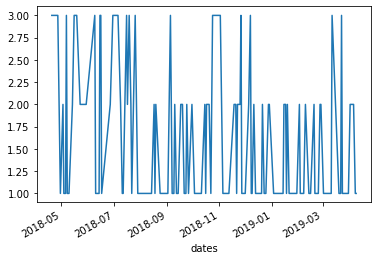

In [145]:
sku_all_groups[sku_all_groups['SKU'] == 32950].groupby('dates')['num_purchases'].sum().plot()

<AxesSubplot:xlabel='dates'>

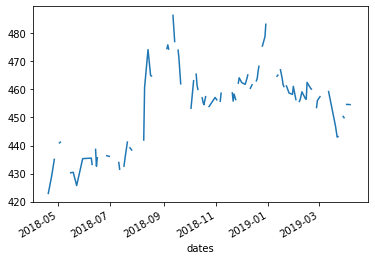

In [147]:
sku_all_groups[sku_all_groups['SKU'] == 32950].groupby('dates')['price_per_sku'].mean().plot()

## Модель спроса, а затем линейная цены от спроса

In [110]:
df_demand = sku_all_groups[['dates', 'SKU', 'num_purchases']]
df_demand.columns = ['ds', 'SKU', 'y']

In [111]:
%%time

forecast = []
for sku in tqdm(sku_from_test):
    df_sku = df_demand[df_demand['SKU'] == sku][['ds', 'y']]
        
    first = df_sku['ds'].min()
    last = df_sku['ds'].max()
    
    df_sku = make_full_dates(df_sku, 'ds', 'y', first, last)
   
    model = Prophet()
    model.fit(df_sku)
    
    future = model.make_future_dataframe(periods=365)
    cur_forecast = model.predict(future)[['ds', 'yhat']]
    cur_forecast['SKU'] = sku
    forecast.append(cur_forecast)
    
forecast = pd.concat(forecast)

  0%|          | 0/25 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -19.7375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       62.9772   4.18902e-06        97.969           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       62.9795   8.41759e-09       100.539      0.4528      0.4528      186   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


  4%|▍         | 1/25 [00:03<01:13,  3.08s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -32.6254
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       236.409   9.70414e-05       88.4822     0.03902           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100        236.41   4.41935e-05       98.4864   4.995e-07       0.001      164  LS failed, Hessian reset 
     153       236.419    6.7916e-09       91.2294      0.2832      0.2832      232   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


  8%|▊         | 2/25 [00:05<00:59,  2.57s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -38.5331
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       262.264   1.10319e-06       97.1582      0.3104      0.3104      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       262.265   8.90365e-09       94.2805           1           1      157   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 12%|█▏        | 3/25 [00:07<00:53,  2.44s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -30.0167
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       372.872   2.90328e-05        92.578           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       372.874   1.97628e-05       107.746   2.098e-07       0.001      155  LS failed, Hessian reset 
     136       372.875   3.42253e-09       97.7094      0.1848      0.1848      198   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 16%|█▌        | 4/25 [00:10<00:52,  2.51s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -28.1755
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       230.295   8.96855e-05       99.6171           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       230.308    9.2241e-05       99.7174   9.671e-07       0.001      186  LS failed, Hessian reset 
     147       230.315   4.22826e-07       85.2606   3.933e-09       0.001      275  LS failed, Hessian reset 
     162       230.315   4.53288e-09       86.3611      0.3311      0.3311      294   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 20%|██        | 5/25 [00:12<00:50,  2.53s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -61.6268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       317.918   0.000208569       104.898           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       318.037      5.89e-05       73.1332           1           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        318.05   1.43675e-07       65.7331      0.8674      0.8674      390   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     319        318.05   6.41278e-09       88.9319      0.4207      0.4207      415   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 24%|██▍       | 6/25 [00:14<00:46,  2.43s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -58.1183
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       358.416   0.000118368       111.662           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       358.644   3.24002e-08       96.9915      0.4587      0.4587      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       358.644   2.95582e-09       82.7213      0.1767      0.1767      254   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 28%|██▊       | 7/25 [00:17<00:42,  2.39s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.2722
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       77.7708   7.90413e-09       95.4735      0.3409      0.3409      106   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 32%|███▏      | 8/25 [00:19<00:42,  2.48s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -49.1474
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       320.625   1.64265e-05       85.3556      0.4511      0.4511      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       320.628   2.22279e-06       93.5845   1.998e-08       0.001      214  LS failed, Hessian reset 
     194       320.628   1.18043e-08       97.8547      0.3278           1      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 36%|███▌      | 9/25 [00:22<00:39,  2.50s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -59.4308
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       244.562   6.45094e-05       97.2681      0.2618      0.2618      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       244.575   7.49297e-09       102.126      0.2381      0.2381      176   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 40%|████      | 10/25 [00:25<00:38,  2.55s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -59.1413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       399.547   0.000192508       70.2378   2.021e-06       0.001      120  LS failed, Hessian reset 
      99       399.558   4.80965e-06       88.9627           1           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       399.558   1.79147e-06       80.7734   2.115e-08       0.001      208  LS failed, Hessian reset 
     115       399.558    9.1622e-09       64.2517      0.1671      0.1671      221   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 44%|████▍     | 11/25 [00:27<00:34,  2.48s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -37.3918
Iteration  1. Log joint probability =    28.8735. Improved by 66.2653.
Iteration  2. Log joint probability =    36.4231. Improved by 7.54963.
Iteration  3. Log joint probability =    45.7538. Improved by 9.33075.
Iteration  4. Log joint probability =    46.3837. Improved by 0.629905.
Iteration  5. Log joint probability =    46.5984. Improved by 0.214652.
Iteration  6. Log joint probability =    46.7265. Improved by 0.12815.
Iteration  7. Log joint probability =     46.737. Improved by 0.010503.
Iteration  8. Log joint probability =    46.8092. Improved by 0.0721712.
Iteration  9. Log joint probability =    46.9033. Improved by 0.0940616.
Iteration 10. Log joint probability =     46.961. Improved by 0.0577576.
Iteration 11. Log joint probability =    46.9714. Improved by 0.0103279.
Iteration 12. Log joint probability =     46.976. Improved by 0.00461264.
Iteration 13. Log joint probability =    46.9801. Improved by 0.00412665.
Iteration 14. Log 

 48%|████▊     | 12/25 [00:31<00:36,  2.84s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -33.8755
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       225.087    0.00025289       74.8854   2.119e-06       0.001      114  LS failed, Hessian reset 
      99       225.098   2.57085e-06       92.0581      0.4355           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       225.099   2.27919e-06       93.3285   2.314e-08       0.001      221  LS failed, Hessian reset 
     135       225.099   9.55864e-09       67.2228      0.2837      0.2837      246   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 52%|█████▏    | 13/25 [00:33<00:32,  2.67s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -22.1948
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       56.4545   5.56599e-09       100.803      0.3156           1      100   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 56%|█████▌    | 14/25 [00:36<00:29,  2.70s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -53.3341
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       489.183   1.13388e-05       91.4293      0.6491      0.6491      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       489.185   3.40065e-09       79.8785      0.0912           1      173   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 60%|██████    | 15/25 [00:39<00:27,  2.76s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -36.9433
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       397.466   8.62314e-05       103.515   8.544e-07       0.001      151  LS failed, Hessian reset 
      99       397.474   3.40743e-06       97.7203      0.1729           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       397.474   9.22607e-09       100.561      0.2854      0.2854      202   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 64%|██████▍   | 16/25 [00:41<00:23,  2.60s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -37.484
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       417.309   1.16188e-07       98.2666   1.173e-09       0.001      153  LS failed, Hessian reset 
      89       417.309   5.40833e-09       94.4484        0.23        0.23      157   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 68%|██████▊   | 17/25 [00:43<00:20,  2.54s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.96234
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       102.713   5.12767e-09       104.104      0.4588      0.4588      123   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 72%|███████▏  | 18/25 [00:46<00:18,  2.58s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -42.3431
Iteration  1. Log joint probability =    47.3781. Improved by 89.7212.
Iteration  2. Log joint probability =    57.1794. Improved by 9.80131.
Iteration  3. Log joint probability =    59.0343. Improved by 1.85493.
Iteration  4. Log joint probability =    59.1978. Improved by 0.163522.
Iteration  5. Log joint probability =    59.2269. Improved by 0.0290467.
Iteration  6. Log joint probability =    59.2561. Improved by 0.0292441.
Iteration  7. Log joint probability =    59.2818. Improved by 0.0256891.
Iteration  8. Log joint probability =    59.2849. Improved by 0.00310221.
Iteration  9. Log joint probability =    59.3381. Improved by 0.0531719.
Iteration 10. Log joint probability =    59.3744. Improved by 0.0363015.
Iteration 11. Log joint probability =    59.4185. Improved by 0.0440821.
Iteration 12. Log joint probability =    59.9267. Improved by 0.508215.
Iteration 13. Log joint probability =    60.0953. Improved by 0.168626.
Iteration 14. Log

 76%|███████▌  | 19/25 [00:50<00:17,  2.91s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -45.0648
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       421.833    3.4978e-06       97.2274           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       421.834   5.34474e-06       99.7823   5.642e-08       0.001      235  LS failed, Hessian reset 
     164       421.834   5.19198e-09       87.8399      0.3597      0.3597      279   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 80%|████████  | 20/25 [00:52<00:13,  2.77s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -47.505
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        321.59   0.000445832       89.9946           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       321.665   1.14752e-07       93.4471           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       321.665   9.94744e-09       80.9063      0.1781      0.7965      267   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 84%|████████▍ | 21/25 [00:54<00:10,  2.64s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -25.3482
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       222.027   7.35837e-06       99.0453           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       222.028   1.76324e-06         96.28   1.736e-08       0.001      161  LS failed, Hessian reset 
     117       222.028   8.42705e-09        101.26       0.258       0.258      182   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 88%|████████▊ | 22/25 [00:57<00:07,  2.55s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -25.5973
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       580.451   1.74091e-07       92.2247   1.712e-09       0.001      165  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       580.451   1.63538e-08       72.6094      0.7686      0.7686      171   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 92%|█████████▏| 23/25 [00:59<00:05,  2.50s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -17.8997
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       141.007   0.000130335       104.835    1.34e-06       0.001      140  LS failed, Hessian reset 
      99       141.035   4.66831e-07       93.2554      0.4514      0.4514      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       141.035   3.63144e-09       91.9226      0.1957      0.1957      192   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 96%|█████████▌| 24/25 [01:02<00:02,  2.50s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -29.1242
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       186.052   1.12092e-08       90.6349      0.3757      0.3757      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       186.052   7.50347e-09        94.076      0.4791      0.4791      131   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


100%|██████████| 25/25 [01:04<00:00,  2.59s/it]


In [113]:
# Модель цены от спроса

df_price = sku_all_groups[sku_all_groups['price_per_sku'].notna()]
X_train = df_price['num_purchases'].values.reshape(-1, 1)
y_train = df_price['price_per_sku'].values

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [114]:
X_test = forecast['yhat'].values.reshape(-1, 1)

forecast['price_per_sku'] = model.predict(X_test)

In [115]:
final = df_test.merge(forecast.drop(columns='yhat'), left_on=['dates', 'SKU'], right_on=['ds', 'SKU'])

In [116]:
final[['dates', 'SKU', 'price_per_sku']].to_csv('./solution/prediction.csv', index=False)

Score = 71.940 as_is
Score = 71.990 заполнили спрос последним валидным значением
Score = 71.988 заполнили спрос нулями

## Если сразу прогнозировать цену

In [53]:
df_price = sku_all_groups[['dates', 'SKU', 'price_per_sku']]
df_price.columns = ['ds', 'SKU', 'y']

In [99]:
%%time

forecast = []
for sku in tqdm(sku_from_test):
    df_sku = df_price[df_price['SKU'] == sku][['ds', 'y']]
    
    first = df_sku['ds'].min()
    last = df_sku['ds'].max()
    
    df_sku = make_full_dates(df_sku, 'ds', 'y', first, last)
    
    # Заполним последним валидным значением
    df_sku.loc[df_sku['y'] == 0, 'y'] = np.nan
    df_sku['y'] = df_sku['y'].fillna(method='ffill')

    model = Prophet()
    model.fit(df_sku)
    
    future = model.make_future_dataframe(periods=365)
    cur_forecast = model.predict(future)[['ds', 'yhat']]
    cur_forecast['SKU'] = sku
    forecast.append(cur_forecast)
    
forecast = pd.concat(forecast)

  0%|          | 0/25 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.06781
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       446.892   0.000273562       117.696   1.665e-06       0.001      144  LS failed, Hessian reset 
      99       447.339   0.000215153       81.5252           1           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       447.886    0.00122013       189.492   1.179e-05       0.001      233  LS failed, Hessian reset 
     199       448.221    0.00018552       68.6177      0.8926      0.8926      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        449.63   2.37968e-05       71.3325      0.2649           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       449.657   0.000104966       89.1348   1.234e-06       0.001      504  LS failed, Hessian rese

  4%|▍         | 1/25 [00:02<01:11,  3.00s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.15425
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1336.75   0.000683799       88.8557           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       1337.13   6.88348e-05       125.784   6.678e-07       0.001      254  LS failed, Hessian reset 
     197       1337.13   3.54794e-08       79.8003      0.3587           1      295   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


  8%|▊         | 2/25 [00:05<01:03,  2.77s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.04848
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1650.66   0.000564078       391.509           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1653.03    0.00138487       280.358           1           1      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     297       1653.74   9.40402e-06       79.2519    1.37e-07       0.001      421  LS failed, Hessian reset 
     299       1653.74   1.07186e-05       55.9657           1           1      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1653.94   2.85826e-05       65.3753           1           1      552   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     424       1653.99   1.86798e-05    

 12%|█▏        | 3/25 [00:07<00:56,  2.58s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.71951
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       1282.73   0.000237121        138.13   2.121e-06       0.001      143  LS failed, Hessian reset 
      99       1282.87   2.96332e-05       64.7473       0.303           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       1282.87   7.07593e-08       59.8408      0.1975           1      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 16%|█▌        | 4/25 [00:10<00:53,  2.54s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.32493
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1042.04    7.5122e-07       81.9687      0.1875      0.1875      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       1042.09   0.000217711       90.9181   3.333e-06       0.001      259  LS failed, Hessian reset 
     199       1042.13   2.18815e-06        86.313      0.3941           1      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       1042.13   4.48189e-06       84.7356   6.906e-08       0.001      353  LS failed, Hessian reset 
     249       1042.13   1.43824e-07       79.0383      0.9644      0.9644      402   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 20%|██        | 5/25 [00:12<00:49,  2.46s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.03452
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2677.08    0.00100318       316.639           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       2677.11   5.29277e-06       100.725   4.144e-08       0.001      165  LS failed, Hessian reset 
     199       2677.46    0.00049984        210.58           1           1      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206        2677.5   2.44568e-05        364.91   7.694e-08       0.001      333  LS failed, Hessian reset 
     299       2677.59   9.89402e-05       88.1398           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       2677.61   5.38917e-05       268.419   5.144e-07       0.001      552  LS failed, Hessian rese

 24%|██▍       | 6/25 [00:15<00:47,  2.52s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02734
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2998.03   0.000650258        2436.4      0.7722      0.7722      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3004.5   0.000281715       176.325           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3006.3   0.000320041       458.716      0.5149     0.05149      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3006.82    6.0631e-05       830.749      0.1472      0.4232      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     460       3007.01   3.52528e-06       132.553   1.355e-08       0.001      589  LS failed, Hessian reset 
     499       3007.06   3.61083e-05    

 28%|██▊       | 7/25 [00:18<00:46,  2.57s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02674
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       595.129    0.00109221       446.353      0.6515      0.6515      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       595.567   1.32544e-05       93.7211   1.546e-07       0.001      222  LS failed, Hessian reset 
     199       595.869   9.78107e-05       93.9326       1.586      0.1586      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       595.888   5.92803e-05       220.213   7.269e-07       0.001      390  LS failed, Hessian reset 
     299       596.084   0.000292034       150.778           1           1      483   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       596.203   4.67835e-05       287.673   2.332e-07       0.001      558  LS failed, Hessian rese

 32%|███▏      | 8/25 [00:20<00:44,  2.61s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.05484
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2329.19    0.00026917        145.41           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2332.54   4.16991e-05       127.252           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2333.06   0.000297195       409.757      0.2605           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     381       2333.44    4.3501e-06       75.8551    4.23e-08       0.001      511  LS failed, Hessian reset 
     399       2333.47   5.36968e-05       92.1234           1           1      534   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     405       2333.48   2.84563e-05    

 36%|███▌      | 9/25 [00:23<00:42,  2.65s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.29987
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1342.32    0.00123645       535.747      0.5686      0.5686      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1360.18    0.00121694       118.811       3.325      0.3325      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1369.95   0.000429903       164.837           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1371.19   0.000539509        299.32      0.8535      0.8535      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1372.77    0.00187463       680.006      0.7645      0.7645      604   
    Iter      log prob        ||dx||      ||grad||       alpha  

 40%|████      | 10/25 [00:25<00:38,  2.59s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02892
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2868.54    0.00128202       214.135           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2870.47    0.00081004        921.32       0.273           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266        2871.2   4.99409e-06       150.085   3.972e-08       0.001      370  LS failed, Hessian reset 
     299        2871.4   0.000112523       123.046           1           1      411   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2871.68   5.05568e-05       143.066        0.28      0.8555      529   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2871.81   1.07021e-05    

 44%|████▍     | 11/25 [00:28<00:34,  2.50s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -31.5556
Iteration  1. Log joint probability =    173.866. Improved by 205.422.
Iteration  2. Log joint probability =    293.899. Improved by 120.033.
Iteration  3. Log joint probability =     301.86. Improved by 7.9612.
Iteration  4. Log joint probability =    301.992. Improved by 0.131689.
Iteration  5. Log joint probability =    302.736. Improved by 0.744178.
Iteration  6. Log joint probability =    303.014. Improved by 0.278447.
Iteration  7. Log joint probability =    303.584. Improved by 0.570052.
Iteration  8. Log joint probability =    304.735. Improved by 1.15037.
Iteration  9. Log joint probability =    306.257. Improved by 1.52267.
Iteration 10. Log joint probability =    306.958. Improved by 0.700489.
Iteration 11. Log joint probability =    307.148. Improved by 0.190522.
Iteration 12. Log joint probability =    308.841. Improved by 1.69236.
Iteration 13. Log joint probability =    309.359. Improved by 0.518244.
Iteration 14. Log joint proba

 48%|████▊     | 12/25 [00:32<00:37,  2.90s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.03664
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2206.29   0.000147827       308.977           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2214.8   0.000673488       291.365           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2216.12    0.00296445       1955.96           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2217.12   8.44314e-05         413.9      0.7608      0.7608      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2217.54   0.000103405       351.589           1           1      596   
    Iter      log prob        ||dx||      ||grad||       alpha  

 52%|█████▏    | 13/25 [00:34<00:33,  2.76s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02956
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       649.988    0.00379154       828.993           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       652.166   0.000101969       93.2943      0.2437      0.2437      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       652.781   1.85482e-05       84.8197           1           1      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308       652.795   8.63939e-06       70.0259   1.068e-07       0.001      427  LS failed, Hessian reset 
     399       652.871   2.74086e-06       62.6595           1           1      549   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     433       652.881   2.58507e-05    

 56%|█████▌    | 14/25 [00:37<00:31,  2.89s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.24774
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2241.02   0.000697046       137.734           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       2241.85   0.000170225           286   8.898e-07       0.001      185  LS failed, Hessian reset 
     199       2243.44   0.000259975       432.287      0.2113      0.2113      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289       2244.68   8.15712e-05       169.065   5.205e-07       0.001      461  LS failed, Hessian reset 
     299       2244.84    0.00161087       243.689           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     393       2245.03   0.000117921       103.006   1.614e-06       0.001      626  LS failed, Hessian rese

 60%|██████    | 15/25 [00:40<00:28,  2.82s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.28354
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1874.43    0.00161644       80.3703      0.3501           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1874.73   2.80825e-05       78.4679           1           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223        1874.9    9.1458e-05       72.6546   4.136e-07       0.001      331  LS failed, Hessian reset 
     292       1875.18   3.62758e-08       83.7181      0.2224           1      420   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 64%|██████▍   | 16/25 [00:42<00:24,  2.72s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.42649
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1749.82   0.000203181       78.4164           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1750.09   0.000214466       81.6943      0.4274           1      269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       1750.15   0.000125434       105.741   1.192e-06       0.001      350  LS failed, Hessian reset 
     240       1750.16   5.72544e-05       83.7585   6.781e-07       0.001      420  LS failed, Hessian reset 
     299       1750.22   6.03345e-05       68.9123      0.7464      0.7464      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1750.23   2.81542e-07       77.3386       0.415       0.415      622   
    Iter      log pro

 68%|██████▊   | 17/25 [00:45<00:20,  2.60s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.03742
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       547.886   0.000510354       88.9861           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       550.726    0.00202637       267.418           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       552.095   0.000466088       76.1893           1           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        552.91   0.000875217       119.329           1           1      489   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       553.019    0.00295931       60.1516           1           1      613   
    Iter      log prob        ||dx||      ||grad||       alpha  

 72%|███████▏  | 18/25 [00:47<00:18,  2.65s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -39.2057
Iteration  1. Log joint probability =    80.6917. Improved by 119.897.
Iteration  2. Log joint probability =     148.25. Improved by 67.5583.
Iteration  3. Log joint probability =    154.391. Improved by 6.14125.
Iteration  4. Log joint probability =    154.482. Improved by 0.0903147.
Iteration  5. Log joint probability =    154.513. Improved by 0.0310158.
Iteration  6. Log joint probability =    154.564. Improved by 0.051447.
Iteration  7. Log joint probability =    154.739. Improved by 0.174614.
Iteration  8. Log joint probability =    154.813. Improved by 0.0742482.
Iteration  9. Log joint probability =    154.815. Improved by 0.00221417.
Iteration 10. Log joint probability =     154.84. Improved by 0.0244334.
Iteration 11. Log joint probability =    154.859. Improved by 0.0197093.
Iteration 12. Log joint probability =    154.904. Improved by 0.0443635.
Iteration 13. Log joint probability =    155.026. Improved by 0.121925.
Iteration 14. Log

 76%|███████▌  | 19/25 [00:51<00:17,  2.98s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.15139
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2530.34   0.000146083       104.411       0.936       0.936      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       2530.66   2.68843e-05       122.303   1.249e-07       0.001      254  LS failed, Hessian reset 
     199       2530.71   8.06731e-06        67.268      0.4306           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2530.74   3.50241e-06       73.5402           1           1      430   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       2530.74   4.46218e-07       78.3503   5.331e-09       0.001      491  LS failed, Hessian reset 
     316       2530.74   6.15336e-08       66.1968       0.345       0.345      500   
Optimization terminat

 80%|████████  | 20/25 [00:53<00:13,  2.76s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.07667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1722.37    0.00372982       655.731           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1737.06   0.000950732       210.958           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1740.8    0.00230472       416.751      0.2197      0.8818      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     369       1741.89   1.58899e-05       114.804   1.353e-07       0.001      497  LS failed, Hessian reset 
     399       1742.25   0.000236972       285.874      0.3877       0.758      535   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1745.25    0.00153646    

 84%|████████▍ | 21/25 [00:56<00:10,  2.65s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.09859
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1227.17   0.000341186       87.8228           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       1227.36   0.000501583       291.213   4.301e-06       0.001      195  LS failed, Hessian reset 
     199       1227.45   9.04197e-07       70.2699      0.4236      0.4236      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       1227.45   2.60543e-08       78.1846      0.3107      0.3107      309   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 88%|████████▊ | 22/25 [00:58<00:07,  2.51s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.39262
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       1932.36     0.0001566       99.1222   1.676e-06       0.001      148  LS failed, Hessian reset 
      99       1932.37    1.7628e-06       71.9751      0.4489      0.4489      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       1932.37   5.12226e-08       81.7655      0.2649           1      202   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 92%|█████████▏| 23/25 [01:00<00:05,  2.51s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.0586
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        879.17   0.000460709       101.497           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154        879.72   6.93402e-05       168.983    2.91e-07       0.001      227  LS failed, Hessian reset 
     199       879.796   6.28691e-06       65.7704      0.4391      0.4391      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       879.813   0.000153208       89.9053   1.536e-06       0.001      351  LS failed, Hessian reset 
     265       879.822   6.51504e-06       65.3967    9.56e-08       0.001      450  LS failed, Hessian reset 
     292       879.822   2.31226e-08       73.8645      0.2021           1      493   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is 

 96%|█████████▌| 24/25 [01:03<00:02,  2.53s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.04602
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1501.33   0.000669511       184.586           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1502.49   9.14556e-05       272.789      0.9613      0.9613      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1502.81   5.12595e-05       74.5862      0.8613      0.8613      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       1502.81   5.04042e-08       64.7993      0.3681      0.3681      416   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]

CPU times: user 1min 3s, sys: 1.81 s, total: 1min 5s
Wall time: 1min 5s


In [100]:
forecast.columns = ['dates', 'price_per_sku', 'SKU']

In [101]:
final = df_test.merge(forecast, on=['dates', 'SKU'])

In [102]:
# final[['dates', 'SKU', 'price_per_sku']].to_csv('./solution/prediction.csv', index=False)

as_is: Score = 36.187
заполнил пропуски нулями: Score = 83.716 
заполнил последним валидным значением: Score = 4.492